In [117]:
import pandas as pd
import networkx as nx
from numpy import array, log10

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import sys
# sys.setdefaultencoding() does not exist, here!
reload(sys)  # Reload does the trick!
sys.setdefaultencoding('UTF8')

In [16]:
# pd.read()

processed_data_path = './../../../../../media/miglesia/Elements/corr_st_data/'

nodes = pd.read_csv(processed_data_path+'nodes_bs.csv').sort_index().reset_index().rename({'Unnamed: 0': 'node_name'}, axis = 1)

edges = pd.read_csv(processed_data_path+'CHI_COM_W4_O4_E2_I4_edges_bs.csv', index_col = 0)[['label_x', 'label_y', 'weight_CHI_COM']]
edges = edges.merge(nodes['node_name'].reset_index(), left_on='label_x', right_on='node_name').merge(
    nodes['node_name'].reset_index(), left_on='label_y', right_on='node_name')[['index_x', 'label_x', 'index_y', 'label_y', 'weight_CHI_COM']]


main_table = pd.read_csv(processed_data_path+'CHI_COM_W4_O4_E2_I4_main_table.csv', index_col = 0)


In [372]:
### Max degree = max_d. Parameter used to trim the network.
max_d = 20; geo = 'CHI_COM'
df1 = edges.groupby('index_x').apply(lambda x: x.nlargest(max_d, 'weight_'+geo)).reset_index(drop = True)
df2 = edges.groupby('index_y').apply(lambda x: x.nlargest(max_d, 'weight_'+geo)).reset_index(drop = True)
edges_max_d = df1.merge(df2, on = ['index_x', 'label_x', 'index_y', 'label_y', 'weight_'+geo]).reset_index(drop = True)

edges_table = edges_max_d.set_index(['index_x', 'index_y'])['weight_CHI_COM'].unstack()
edges_table.index.name = edges_table.columns.name = None
edges_table = (edges_table.fillna(0) + edges_table.fillna(0).T)/2.
###

# G = nx.from_pandas_dataframe(edges_max_d, 'label_x', 'label_y', 'weight_'+geo)
G = nx.from_pandas_dataframe(edges_max_d, 'index_x', 'index_y', ['weight_'+geo, 'label_x', 'label_y'])

In [254]:
# main_tables = pd.concat([pd.read_csv('./../../../../../media/miglesia/Elements/corr_st_data/CHI_COM_W4_O4_E2_I4_main_table_2011_2012.csv'),
#            pd.read_csv('./../../../../../media/miglesia/Elements/corr_st_data/CHI_COM_W4_O4_E2_I4_main_table_2011_2013.csv'),
#            pd.read_csv('./../../../../../media/miglesia/Elements/corr_st_data/CHI_COM_W4_O4_E2_I4_main_table_2012_2013.csv'),
#            pd.read_csv('./../../../../../media/miglesia/Elements/corr_st_data/CHI_COM_W4_O4_E2_I4_main_table_2014_2011.csv'),
#            pd.read_csv('./../../../../../media/miglesia/Elements/corr_st_data/CHI_COM_W4_O4_E2_I4_main_table_2014_2012.csv'),
#            pd.read_csv('./../../../../../media/miglesia/Elements/corr_st_data/CHI_COM_W4_O4_E2_I4_main_table_2014_2013.csv')])

main_table = main_tables.groupby('CHI ID COM').mean()/2.

# change node names into node index
main_table.rename(columns = dict(zip(nodes.node_name, nodes.index)), inplace = True)

In [373]:
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns; sns.set(style="ticks", color_codes=True)
from numpy import inf, clip
kwd = "Exports of '89 -"
ix = nodes.loc[nodes['node_name'].str.contains(kwd)]['index'].values[0]
ix
data_neigh = log10(clip(main_table[[ix] + G.neighbors(ix)], 1, inf))
edges_neigh = edges_table[[ix] + G.neighbors(ix)].loc[[ix] + G.neighbors(ix)]

In [375]:
robustness_th = 60
robust_neighs = data_neigh.notnull().sum() > robustness_th
data_neigh_robust = data_neigh.T[robust_neighs].T.fillna(0)
edges_neigh_robust = edges_neigh[robust_neighs].T[robust_neighs].fillna(0)

edges_table_zsc = edges.set_index(['index_x', 'index_y'])['weight_CHI_COM'].unstack()
edges_table_zsc.index.name = edges_table_zsc.columns.name = None
edges_table_zsc = edges_table_zsc[[ix] + G.neighbors(ix)].loc[[ix] + G.neighbors(ix)]
edges_neigh_zsc_robust = edges_table_zsc[robust_neighs].T[robust_neighs]

#label
label_strings = dict(zip(nodes.index.astype(str), nodes.node_name))

from scipy import stats
def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)
    
from numpy import nan
def z_score(z_df, i, j, **kws):
    z_score = z_df.iloc[i, j]
    if z_score == z_score:
        ax.annotate("z = {:.2f}".format(z_score),
                    xy=(.1, .8), xycoords=ax.transAxes)

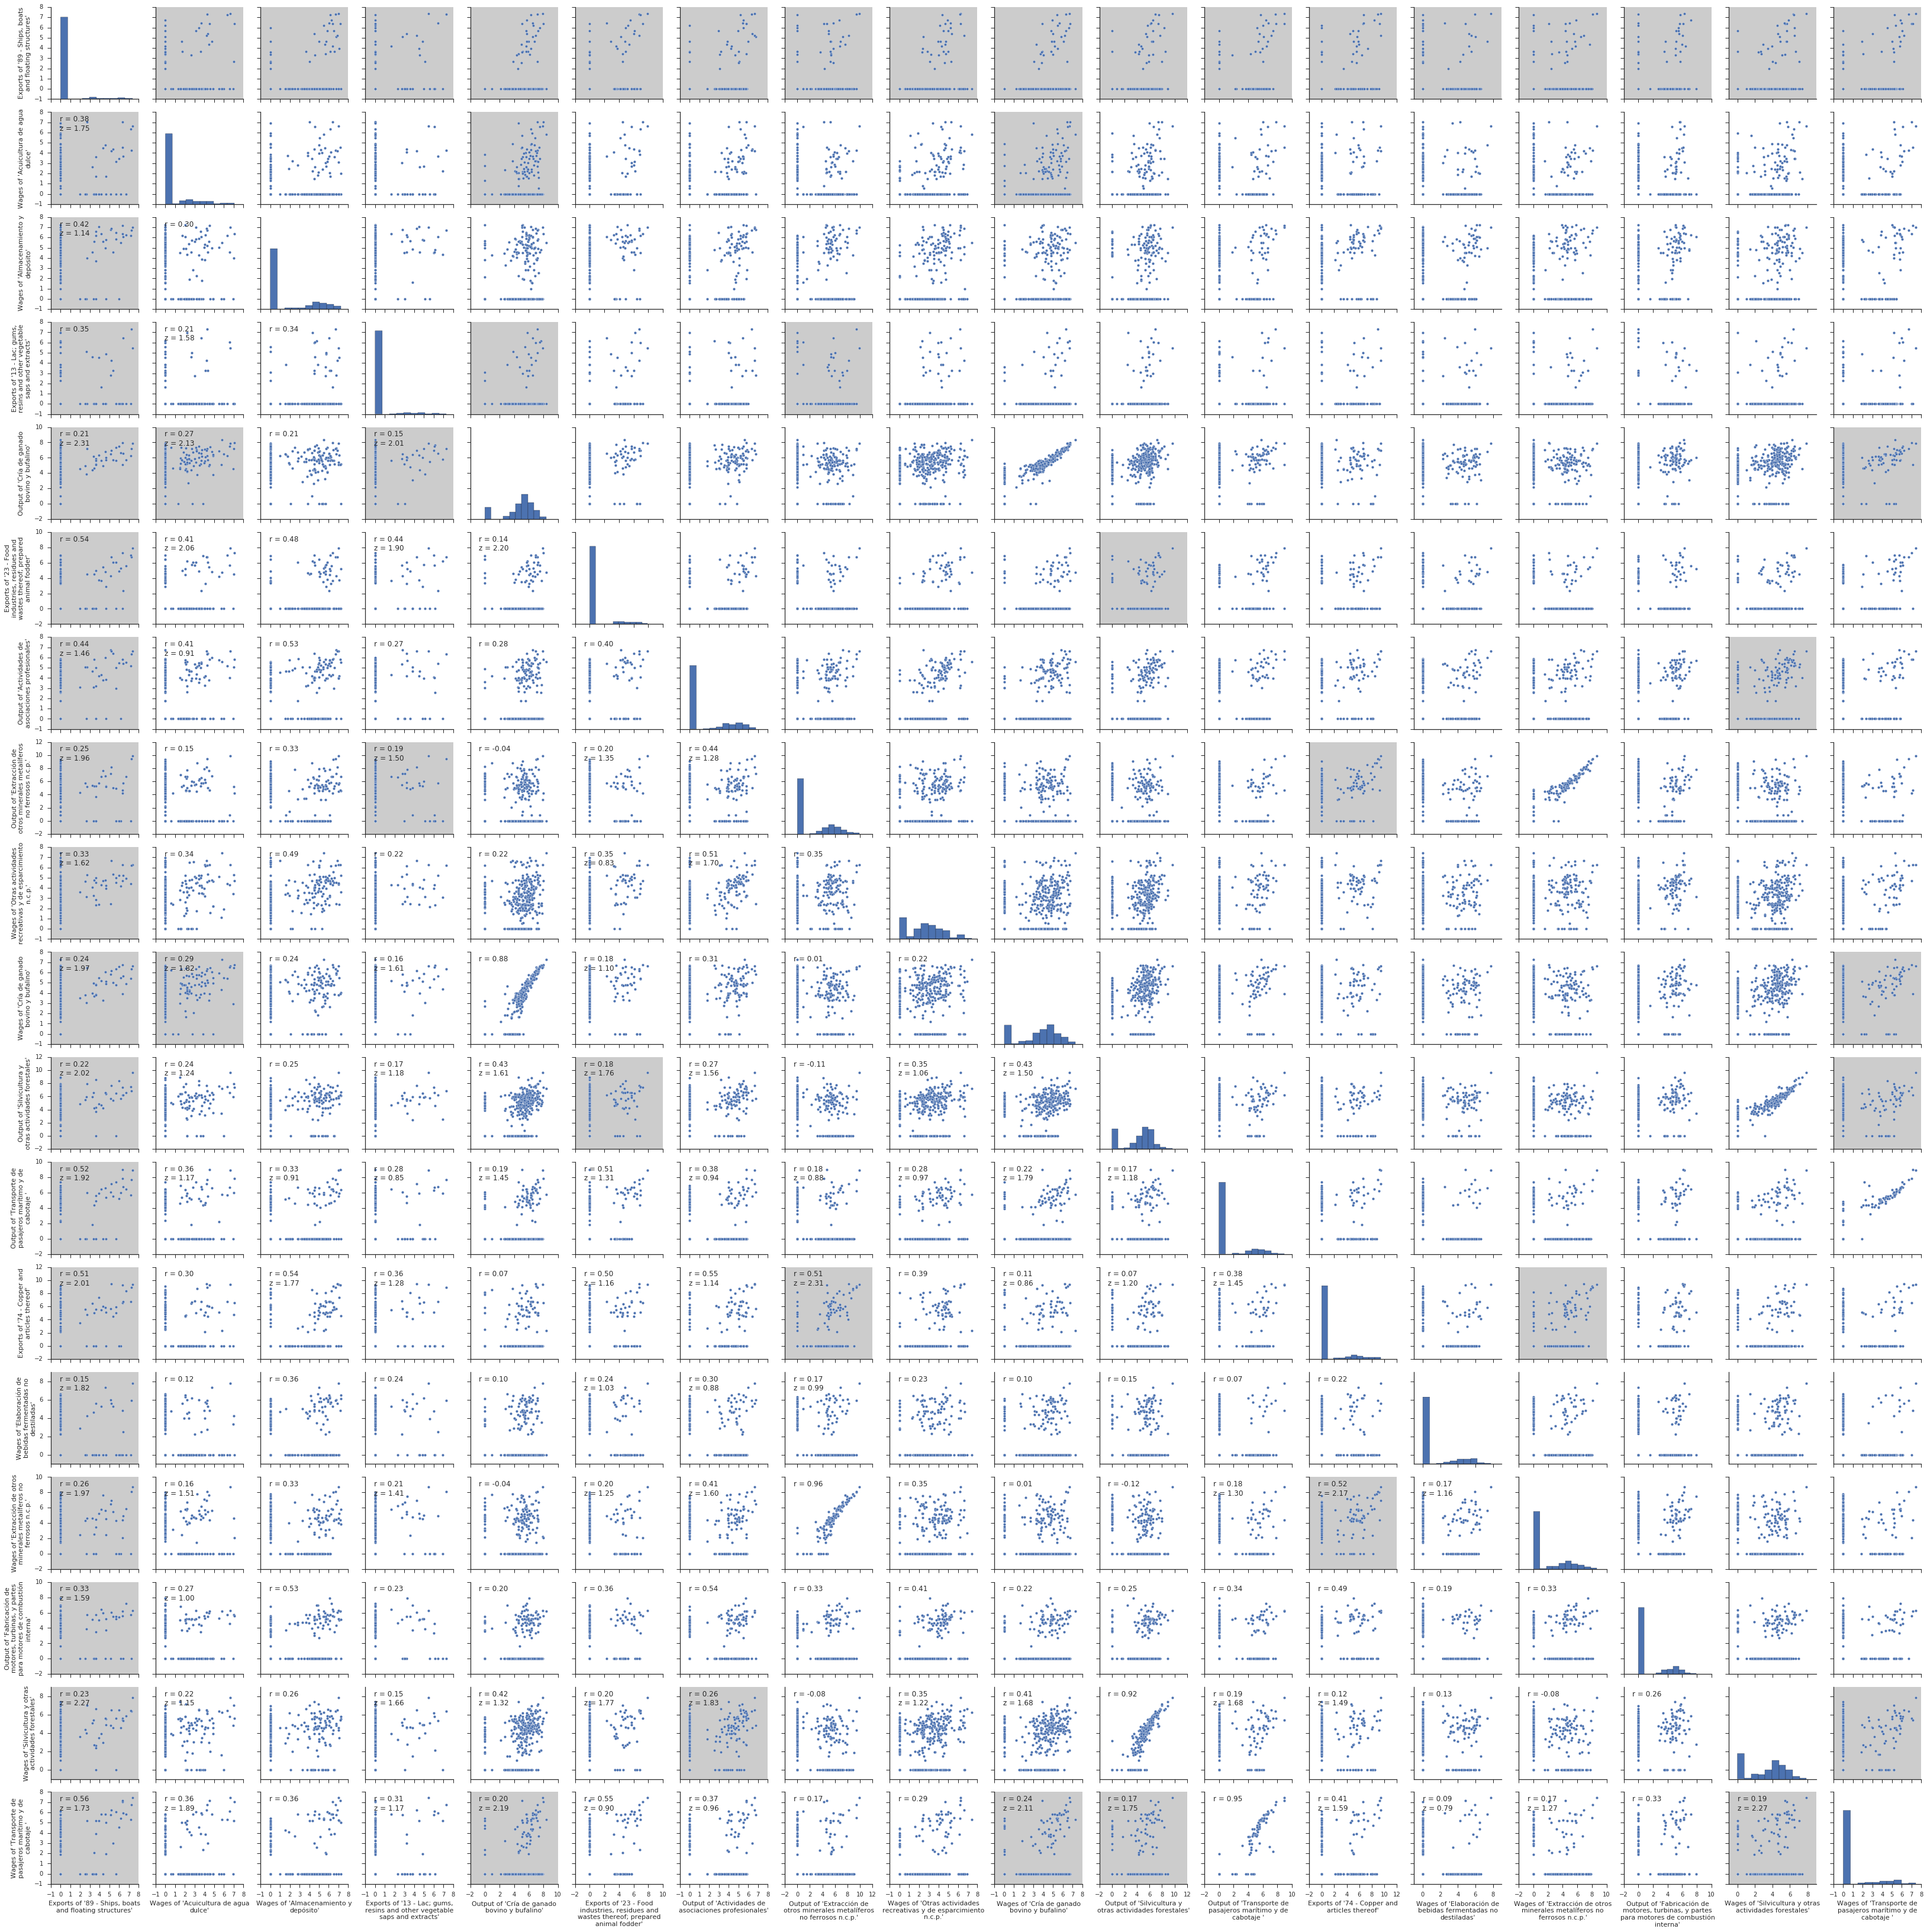

In [376]:
plot = sns.pairplot(data_neigh_robust, dropna = True)

plot.map_lower(corrfunc)

n_plots = len(plot.diag_axes)

import textwrap
for i in range(n_plots):
    for j in range(n_plots):
        xlabel = plot.axes[i][j].get_xlabel()
        ylabel = plot.axes[i][j].get_ylabel()
        if xlabel in replacements.keys():
            plot.axes[i][j].set_xlabel('\n'.join(textwrap.wrap(label_strings[xlabel], 30)))
        if ylabel in replacements.keys():
            plot.axes[i][j].set_ylabel('\n'.join(textwrap.wrap(label_strings[ylabel], 30)))

for i in range(n_plots):
    for j in range(n_plots):
        edge_weight = edges_neigh_robust.iloc[i, j]/2.5
        if edge_weight > 0:
            plot.axes[i][j].set_axis_bgcolor((.8, .8, .8)) #Gray scale
        
for i in range(n_plots):
    for j in range(n_plots):
        if i > j:
            ax = plot.axes[i][j]
            z_score(edges_neigh_zsc_robust, i, j)

In [362]:
z_score

<function __main__.z_score>

In [350]:
# edges_table#[robust_neighs]

